# Example for Image-Kernel using Vietoris-Rips complexes

On this notebook we will explore some Vietoris-Rips complexes and their relations to the image kernel algorithm. 

© Copyright 2022, Álvaro Torras Casas, part of PerMaViss project

In [1]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

np.random.seed(10)


In [2]:
mpl.font_manager.FontManager(size=20)

In [3]:
import permaviss

from permaviss.sample_point_clouds.examples import random_circle, take_sample

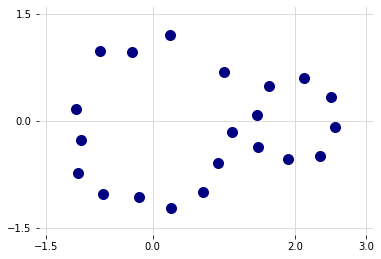

In [4]:
C1 = random_circle(100, 1, 0.3, seed=10)    # random points around a circle of radius 1
C1 = take_sample(C1, 13, seed=4)   # subsample by using the min-max algorithm
C2 = random_circle(100, 0.5, 0.3, center=[2,0], seed=10)    # random points around a circle of radius 1
C2 = take_sample(C2, 8, seed=4)   # subsample by using the min-max algorithm

X = np.concatenate([C1, C2], axis=0)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6,6))

def plot_subpoints_circle(point_cloud, xlim, xticks, color, axis):
    axis.set(frame_on=False)
    axis.set_aspect('equal')
    axis.grid(c='lightgray')
    axis.scatter(point_cloud[:,0], point_cloud[:,1], s=100, c=color)
    axis.set_xlim(xlim)
    axis.set_ylim([-1.6,1.6])
    axis.set_xticks(xticks)
    axis.set_yticks([-1.5,0,1.5])
    

plot_subpoints_circle(X, [-1.6,3.1], [-1.5,0, 2,3], 'navy', ax)  
plt.savefig("figures/sample_circle.png", pad_inches=0.05, bbox_inches=None)

Compute Vietoris Rips complex

In [5]:
from permaviss.simplicial_complexes.vietoris_rips import vietoris_rips

import scipy.spatial.distance as dist

import time
from permaviss.simplicial_complexes.differentials import complex_differentials
from permaviss.persistence_algebra.PH_classic import persistent_homology

Dist_X = dist.squareform(dist.pdist(X))

p = 5 # perform computations on Z mod 5
max_r = 2
max_dim = 3
C, R = vietoris_rips(Dist_X, max_r, max_dim)

start = time.time()
Diff = complex_differentials(C, p=5)
end = time.time()
print("Computing differentials took " + "{:.2f}".format(end - start) + " seconds.")
start = end
Hom, Im, PreIm = persistent_homology(Diff, R, max_r, p)
end = time.time()
print("Computing persistent homology took " + "{:.2f}".format(end - start) + " seconds.")

Computing differentials took 3.06 seconds.
Computing persistent homology took 2.06 seconds.


Plot sequence of Vietoris Rips complexes as wel as sequence of persistent homology in dimension 1

In [6]:
blues = mpl.cm.get_cmap('Blues') # get colormap for plotting

# plot cycle representative #################################################

def plot_complex_noisy_circle(C, R, max_plotting_r, point_cloud, axis):
    axis.set(frame_on=False)
    axis.set_aspect('equal')
    axis.grid(c='lightgray')

    # plot 2D simplices
    for idx, triangle in enumerate(C[2]):
        if R[2][idx] < max_plotting_r:
            vertices = point_cloud[triangle]
            axis.fill(vertices[:, 0], vertices[:, 1], facecolor=blues(R[2][idx]/(5*max_plotting_r)))
    # plot edges 
    for idx, edge in enumerate(C[1]):
        if R[1][idx] < max_plotting_r:
            vertices = point_cloud[edge]
            axis.plot(vertices[:, 0], vertices[:, 1], color=blues(R[1][idx]/(2*max_plotting_r)))
             
    # scatter plot 
    axis.scatter(point_cloud[:,0], point_cloud[:,1], s=60, c='navy', zorder=2.5, label='Point Cloud')

    # set axes layout
    axis.set_xlim([-1.6,3.1])
    axis.set_ylim([-1.6,1.6])
    axis.set_xticks([-1.5,0,2,3])
    axis.set_yticks([-1.5,0,1.5])

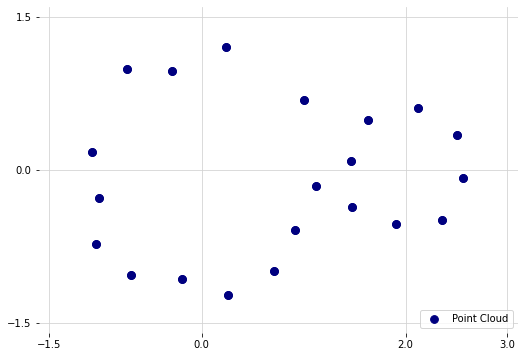

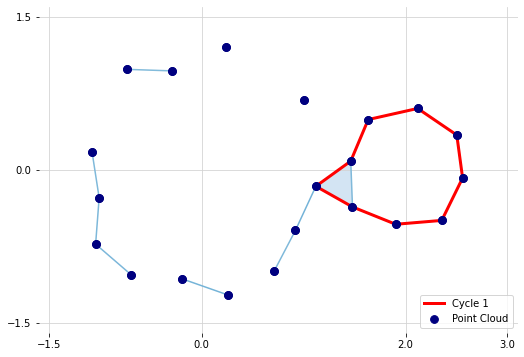

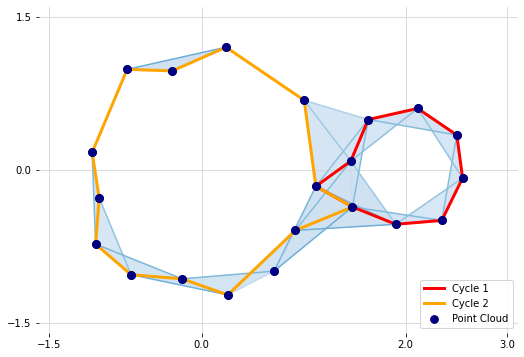

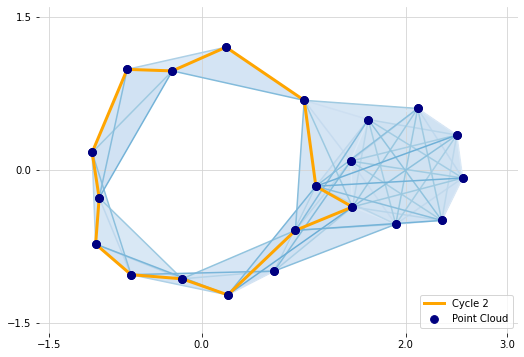

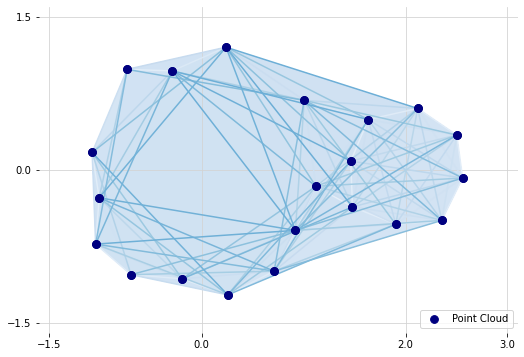

In [8]:
max_plotting_r = 1.9 # set maximum filtration for plotting purposes
  

for idx_max_r, max_plotting_r in enumerate([0.1, 0.5, 1, 1.5, 2]):
    fig = plt.figure(figsize=(12,6))

    ax = fig.add_subplot(1,1,1)

    plot_complex_noisy_circle(C, R, max_plotting_r, X, ax)            

    # add cycle representatives
    for idx_cycle, bar_cycle in enumerate(Hom[1].barcode):
        if (max_plotting_r >= bar_cycle[0]) and (max_plotting_r < bar_cycle[1]):
            for idx, coeff in enumerate(Hom[1].coordinates[:, idx_cycle]):
                if coeff != 0:
                    edge = C[1][idx] # get edge from index
                    vertices = X[edge] # recover vertices
                    if idx_cycle==0:
                        ax.plot(vertices[:, 0], vertices[:, 1], color='red', linewidth=3, label='Cycle 1')
                    else:
                        ax.plot(vertices[:, 0], vertices[:, 1], color='orange', linewidth=3, label='Cycle 2')
        
    # scatter plot 
    ax.scatter(X[:,0], X[:,1], s=60, c='navy', zorder=2.5, label='Point Cloud')

    #set labels 
    # avoid repeating labels on legend 
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles)) # dictionary deletes repeating labels
    ax.legend(by_label.values(), by_label.keys(), loc='lower right')

    # save figure ########################################################

    plt.savefig("figures/diagram_rep_circle_" + str(idx_max_r) + ".png", pad_inches=0.05, bbox_inches=None)